### Transverse Field Ising Model (TFIM)

The Transverse Field Ising Model (TFIM) is a foundational model in quantum mechanics, especially useful for studying phase transitions and quantum magnetism. It consists of qubits arranged in a line, with each qubit influenced by a transverse magnetic field and interacting with its neighbors. This combination of field and interaction terms creates a rich ground state structure and enables exploration of quantum phenomena such as entanglement and coherence.

In this example, the **Hamiltonian** for the TFIM on $ n = 6 $ qubits includes two main terms:

1. **Field Term:** Each qubit is influenced by a transverse field along the $ Z $-axis, represented by:

   $$
   H_{\text{field}} = \sum_{j=0}^{n-1} Z_j
   $$

Here, each $ Z_j $ acts only on qubit $ j $, while identity matrices $ I $ act on the remaining qubits.

2. **Interaction Term:** Each qubit interacts with its nearest neighbor in the $ X $-basis, defined as:

   $$
   H_{\text{interaction}} = \sum_{j=0}^{n-1} X_j X_{(j+1) \ \text{mod} \ n}
   $$

   This term creates interactions between each qubit $ j $ and its neighbor $(j+1) \ \text{mod} \ n$, introducing correlations in the system.

The total Hamiltonian for the TFIM is:

$$
H = H_{\text{field}} + H_{\text{interaction}}
$$

This is implemented as an `AnalogGate` object, which the circuit evolves under for a duration of 1 unit. By measuring the qubits after this evolution, we obtain information about the system’s ground state, which encodes properties of the transverse field and interaction effects in the Ising model.


In [1]:
import functools
import itertools
import operator
import warnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from oqd_analog_emulator.qutip_backend import QutipBackend
from oqd_core.backend.metric import Expectation
from oqd_core.backend.task import Task, TaskArgsAnalog
from oqd_core.interface.analog.operation import AnalogCircuit, AnalogGate
from oqd_core.interface.analog.operator import PauliI, PauliX, PauliY, PauliZ

warnings.filterwarnings("ignore")

In [2]:
def sum(args):
    return functools.reduce(operator.add, args)


def prod(args):
    return functools.reduce(operator.mul, args)


def tensor(args):
    return functools.reduce(operator.matmul, args)

In [3]:
X, Y, Z, I = PauliX(), PauliY(), PauliZ(), PauliI()  # noqa: E741


n = 6

In [4]:
field = sum([tensor([X if i == j else I for i in range(n)]) for j in range(n)])
interaction = sum(
    [tensor([Z if j in (i, (i + 1) % n) else I for j in range(n)]) for i in range(n)]
)

hamiltonian = AnalogGate(hamiltonian=field + interaction)

circuit = AnalogCircuit()
circuit.evolve(duration=1, gate=hamiltonian)
circuit.measure()

In [5]:
# define task args
args = TaskArgsAnalog(
    n_shots=1000,
    fock_cutoff=4,
    metrics={
        f"Z_{i}": Expectation(operator=tensor([Z if j == i else I for j in range(n)]))
        for i in range(n)
    },
    dt=1e-2,
)
task = Task(program=circuit, args=args)

In [6]:
backend = QutipBackend()
results = backend.run(task=task)

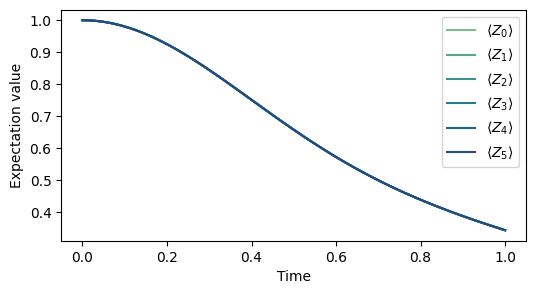

In [7]:
fig, ax = plt.subplots(1, 1, figsize=[6, 3])
colors = sns.color_palette(palette="crest", n_colors=max([4, n]))

for k, (name, metric) in enumerate(results.metrics.items()):
    ax.plot(results.times, metric, label=f"$\\langle {name} \\rangle$", color=colors[k])
ax.legend()
ax.set(xlabel="Time", ylabel="Expectation value");

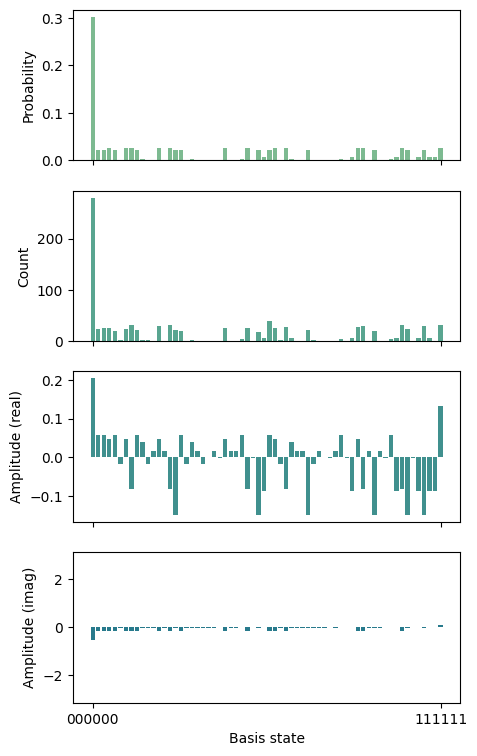

In [8]:
fig, axs = plt.subplots(4, 1, sharex=True, figsize=[5, 9])

state = np.array([basis.real + 1j * basis.imag for basis in results.state])
bases = ["".join(bits) for bits in itertools.product("01", repeat=n)]
counts = {basis: results.counts.get(basis, 0) for basis in bases}

ax = axs[0]
ax.bar(x=bases, height=np.abs(state) ** 2, color=colors[0])
ax.set(ylabel="Probability")


ax = axs[1]
ax.bar(x=bases, height=list(counts.values()), color=colors[1])
ax.set(ylabel="Count")


ax = axs[2]
ax.bar(x=bases, height=state.real, color=colors[2])
ax.set(ylabel="Amplitude (real)")

ax = axs[3]
ax.bar(x=bases, height=state.imag, color=colors[3])
ax.set_xticks([bases[0], bases[-1]])
ax.set(xlabel="Basis state", ylabel="Amplitude (imag)", ylim=[-np.pi, np.pi]);